In [2]:
import numpy as np
import pandas as pd
import os
import nibabel as nb
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pathlib import Path
import json

import src.freesurfer_utils as fsu
import src.preprocessing_volumes as ppv
import ipywidgets as widgets
import h5py



## Test load

In [3]:
subjects_dir = "/Users/benparker/Desktop/cnl/neurocluster/weiner/HCP/subjects"
brain = nb.load(f"{subjects_dir}/100206/mri/orig.mgz")


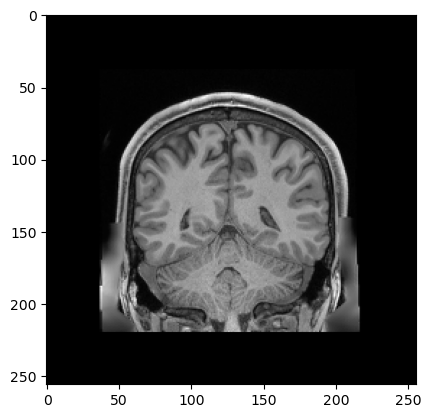

In [ ]:
bdata = brain.get_fdata()
plt.imshow(bdata[:,:,100].T, cmap='gray')

In [ ]:
annot = nb.load('/Users/benparker/Desktop/cnl/neurocluster/HCP/subjects/100307/mri/lh.PFC_LPC_PMC.nii.gz')
annot = annot.get_fdata()

In [ ]:
np.unique(annot)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47.])

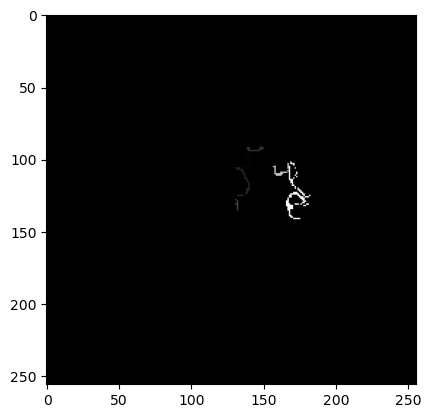

In [ ]:
plt.imshow(annot[:,:,100].T, cmap='gray')

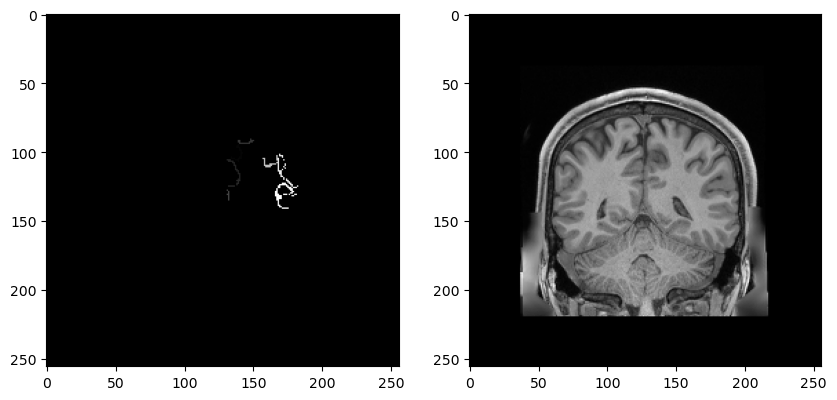

In [ ]:
stacked = np.stack([bdata, annot])
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(stacked[1,:,:,100].T, cmap='gray');
ax[1].imshow(stacked[0,:,:,100].T, cmap='gray');

## Plan  
  
  - load all brains and annotations into dictionary
  - load subject ctab dictionary
  - for each ctab for each hemi, reference main list of sulci for index when all sulci are present
  - for each annotation, reassign voxel values to sulci indexes

In [ ]:
subjects_dir = "/Users/benparker/Desktop/cnl/neurocluster/weiner/HCP/subjects"
subjects_path_list = fsu.get_subjects_list(subjects_dir=subjects_dir, 
                                           subjects_list="/Users/benparker/Desktop/cnl/neurocluster/weiner/HCP/subject_lists/HCP_processed_subs_all.txt")[0]
subjects_path_list = [subjects_path_list]                  
# subjects_dir = "/Users/benparker/Desktop/cnl/subjects"
# subjects_path_list = fsu.get_subjects_list(subjects_dir=subjects_dir, 
#                                            subjects_list="/Users/benparker/Desktop/cnl/subjects/subjects_list.txt")[:2]


subjects = [Path(subject_path).name for subject_path in subjects_path_list]
subjects_path_list

['/Users/benparker/Desktop/cnl/neurocluster/weiner/HCP/subjects/100206']

In [ ]:
def load_brains_and_annots(subjects_path_list : list, annot_name: str) -> dict:
    """ 
    Loads brain.mgz and {annot}.nii.gz from cluster, saves them under subject name in a dict

    Parameters
    ----------
    subjects_path_list : list - list of subject paths
    annot_name : str - annotation name

    Returns
    -------
    brains : dict - brains.mgz from each subject
    """
    brains = {}
    
    subjects = [Path(subject_path).name for subject_path in subjects_path_list]
    for idx, subject_path in enumerate(subjects_path_list):
        brains[subjects[idx]] = [nb.load(f"{subject_path}/mri/brain.mgz").get_fdata()]
        brains[subjects[idx]].append(nb.load(f"{subject_path}/mri/lh.{annot_name}.nii.gz").get_fdata())
        brains[subjects[idx]].append(nb.load(f"{subject_path}/mri/rh.{annot_name}.nii.gz").get_fdata())
    
    return brains

brains = ppv.load_brains_and_annots(subjects_path_list = subjects_path_list, annot_name='PFC_LPC_PMC')
# brains['100307'][0].shape

# brains = ppv.load_brains_and_annots(subjects_path_list = subjects_path_list, annot_name='ribbon')
# brains['100307'][0].shape


In [ ]:
from sys import getsizeof

print(f"{len(subjects)} volumes and annots = {getsizeof(brains)} bytes")

1 volumes and annots = 184 bytes


In [ ]:
brains.keys()

dict_keys(['100206'])

Load dictionary of subject-hemi sulci

In [ ]:
annot_idxs_path = "/Users/benparker/Desktop/cnl/neurocluster/HCP/projects/CNL_scalpel/annot_ctab_json/PFC_LPC_PMC.json"
# annot_idxs_path = "/Users/benparker/Desktop/cnl/subjects/annot_ctab_json/test_annot.json"
with open(annot_idxs_path, 'r', encoding='utf-8') as annot_idxs:
    annot_idxs = json.load(annot_idxs)

annot_idxs['lh_100307'][:10]

['MCGS',
 'POS',
 'prculs',
 'prcus_p',
 'prcus_i',
 'prcus_a',
 'spls',
 'ifrms',
 'sps',
 'icgs_p']

Load all sulci, and add to dictionary of indices

In [ ]:

sulci_list = ['MCGS',
        'POS',
        'prculs',
        'prcus_p',
        'prcus_i',
        'prcus_a', 
        'spls', 
        'ifrms',
        'sps',
        'sspls_d', 
        'icgs_p',
        'pmcgs',
        'sspls_v',
        'prculs_v',
        'isms'   ,
        'central',
        'sprs',
        'iprs', 
        'sfs_a', 
        'sfs_p', 
        'pmfs_p', 
        'pmfs_i', 
        'pmfs_a', 
        'ifs', 
        'infs_h', 
        'infs_v',
        'painfs_d', 
        'painfs_v',
        'ds', 
        'aalf', 
        'half', 
        'ts', 
        'prts', 
        'lfms',
        'IPS', 
        'IPS-PO', 
        'SPS', 
        'aipsJ', 
        'sB', 
        'pips', 
        'iTOS', 
        'mTOS', 
        'SmgS', 
        'STS', 
        'cSTS1', 
        'cSTS2', 
        'cSTS3',
        'SLOS', 
        'SLOS2', 
        'SLOS3', 
        'SLOS4'
        ]

all_sulci_idx = {}
for i, sulcus in enumerate(sulci_list):
    all_sulci_idx[sulcus] = i

print(f" Index for MCGS: {all_sulci_idx['MCGS']}\n",
f"Index for cSTS3: {all_sulci_idx['cSTS3']}")

 Index for MCGS: 0
 Index for cSTS3: 46


For each subject hemi, load a create a dict of index mapping as well

For each subject_hemi, find sulcus __incorrect index__ for each sulcus in subject_hemi_sulci_idx and the corresponding __correct index__ in all_sulci_idx.   
  
The for each subject_hemi annot in brains dict, reassign voxel values of incorrect index to correct index.

In [ ]:
all_sulci_idx2 = ppv.create_dict_from_list_by_index(sulci_list)


In [ ]:
subject_hemi_sulci_idx = ppv.create_subject_hemi_sulci_idx(annot_idxs)

In [ ]:
brains_masked = ppv.mask_brains_from_annot(subjects=subjects, brains=brains, all_sulci=sulci_list, 
                                           annot_idxs=annot_idxs, subject_hemi_sulci_idx=subject_hemi_sulci_idx)

In [ ]:
subjects

['100206']

In [ ]:
np.nonzero(brains_masked['100206'][55])

(array([107, 107, 107, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108,
        108, 108, 108, 108, 108, 108, 109, 109, 109, 109, 109, 109, 109,
        109, 109, 109, 109, 109, 109, 109, 109, 109, 110, 110, 110, 110,
        110, 110, 110, 110, 110, 110, 110, 110, 110, 111, 111, 111, 111,
        111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 112,
        112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112,
        112, 112, 112, 112, 112, 113, 113, 113, 113, 113, 113, 113, 113,
        113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 114, 114,
        114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114,
        114, 114, 114, 114, 115, 115, 115, 115, 115, 115, 115, 115, 115,
        115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115,
        115, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116,
        116, 116, 116, 116, 116, 116, 116, 116, 116, 117, 117, 117, 117,
        117, 117, 117, 117, 117, 117, 117, 117, 117

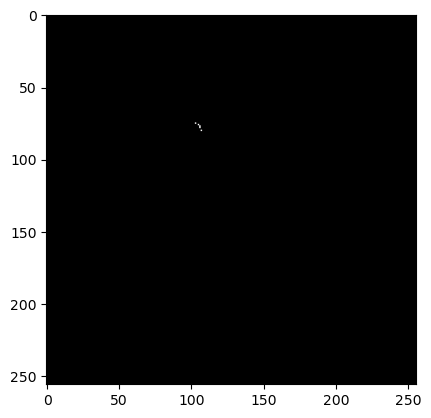

In [ ]:
plt.imshow(brains_masked['100206'][5][131,:,:].T, cmap='gray')  ;

In [ ]:
def plot_brain_and_masks(brain : list, by_chunks=False) -> None:
    """ 
    Plots brain and masks from a subject

    Parameters
    ----------
    brain : list - brain and masks from a subject
    """
    fig, ax = plt.subplots(3, len(brain) // 3, figsize=(300, 50))


    ax[0, 0].imshow(brain[0][:,:,100].T, cmap='gray')
    ax[0, 0].set_title(f"Volume 0")
    
    for idx, volume in enumerate(brain[1:]):
        nonzero = np.nonzero(volume)
        if np.sum(nonzero) != 0 : 
            try: 
                ax[idx % 3, idx // 3].imshow(volume[:,:, nonzero[2][0]].T, cmap='gray')
                ax[idx % 3, idx // 3].set_title(f"Volume {idx}")
            except IndexError:
                pass
        else: 
            try:
                ax[idx % 3, idx // 3].imshow(volume[:,:,100].T, cmap='gray')
                ax[idx % 3, idx // 3].set_title(f"Volume {idx}")
            except IndexError:
                pass
        
    plt.tight_layout()

In [ ]:
plot_brain_and_masks(brains_masked['100206']) 

In [ ]:
def split_volume(np_arr, chunk_size, stride_size):
    """ Splits an np array of shape (nchannels, nx, ny, nz)
    """
    shape = np_arr.shape
    
    assert len(shape) == 4
    assert shape[1] == shape[2] == shape[3]
    
    num_chunks = ((shape[1] - chunk_size) // stride_size) + 1

    chunks_lvl0 = []
    
    # triple loop over x, y, z dimensions of volume 
    for xc in range(num_chunks):
        x0 = xc * stride_size
        x1 = x0 + chunk_size
        
        chunks_lvl1 = []
        for yc in range(num_chunks):
            y0 = yc * stride_size
            y1 = y0 + chunk_size
            
            chunks_lvl2 = []
            for zc in range(num_chunks):
                z0 = zc * stride_size
                z1 = z0 + chunk_size
        
                chunk = np_arr[:, x0:x1, y0:y1, z0:z1]
                chunks_lvl2.append(chunk)
            
            # zoom out 
            chunks_lvl1.append(chunks_lvl2)
        chunks_lvl0.append(chunks_lvl1)

    return chunks_lvl0

In [ ]:

def display_volume(volume):
    def plot_slice(slice_idx=0):
        plt.imshow(volume[slice_idx,:,:], cmap='gray')
        plt.title(f"Slice {slice_idx}")
        plt.axis('off')
        plt.show()

    slice_slider = widgets.interactive(plot_slice, 
                                       slice_idx=(0, volume.shape[0]-1))
    display(slice_slider)



mcgs = np.expand_dims(brains_masked['100206'][1], axis=0)

In [ ]:
chunks = split_volume(mcgs, 84, 56)

In [ ]:
chunks

[[[array([[[[0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            ...,
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.]],
   
           [[0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            ...,
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.]],
   
           [[0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            ...,
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.]],
   
           ...,
   
           [[0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
           

In [ ]:
chunks_full = []
for i in range(3):
    for j in range(3):
        for z in range(3):
            if np.any(chunks[i][j][z] != 0):
                chunks_full.append([i, j, z])
            

In [ ]:
chunks_full

[[1, 0, 1], [1, 1, 1], [1, 2, 1], [2, 0, 1], [2, 1, 1], [2, 2, 1]]

In [ ]:
3display_volume(mcgs)

interactive(children=(IntSlider(value=0, description='slice_idx', max=255), Output()), _dom_classes=('widget-i…

This code saves a subject, confirmed as writing the same data on read

In [ ]:
# f = h5py.File('/Users/benparker/Desktop/cnl/subjects/test_images.h5', 'w')
# for grp_name in subjects:
#     print(grp_name)
#     grp = f.create_group(grp_name)
#     for idx, volume in enumerate(brains_masked[grp_name]):
#         dset = grp.create_dataset(f'volume_{idx}', (256, 256, 256), dtype='float64' , data = volume)

       
        # print(f'{idx} for {grp_name} is {byte_array[50]}')
        
      

In [ ]:
# for subject in subjects:
#     save_file = h5py.File(f"/Users/benparker/Desktop/cnl/neurocluster/HCP/projects/CNL_scalpel/{subject}_images.h5", 'w')
#     print(f"Saving {subject}")
#     print("\n\n\n")
#     for idx, volume in enumerate(brains_masked[subject]):
#         save_file.create_dataset(f'volume_{idx}', (256, 256, 256), dtype='float64' , data = volume)
#         print(f"Saving volume #{idx}")
#         print("\n\n\n")
    

In [ ]:
import gc

for sub_idx, subject in enumerate(subjects):
    brain = ppv.load_brains_and_annots(subjects_path_list=subjects_path_list[sub_idx], annot_name='PFC_LPC_PMC')
    all_sulci_idx2 = ppv.create_dict_from_list_by_index(sulci_list)
    subject_hemi_sulci_idx = ppv.create_subject_hemi_sulci_idx(annot_idxs)
    brains_masked = ppv.mask_brains_from_annot(subjects=[subject], brains=brains, all_sulci=sulci_list, 
                                             annot_idxs=annot_idxs, subject_hemi_sulci_idx=subject_hemi_sulci_idx)
    
    save_file = h5py.File(f"/Users/benparker/Desktop/cnl/subjects/{subject}_images.h5", 'w')
    print(f"Saving {subject}")
    print("\n\n\n")
    for idx, volume in enumerate(brains_masked[subject]):
        save_file.create_dataset(f'volume_{idx}', (256, 256, 256), dtype='float64' , data = volume)
        print(f"Saving volume #{idx}")
        print("\n\n\n")
    save_file.close()
    gc.collect()

In [ ]:
test_sub = h5py.File('/Users/benparker/Desktop/cnl/subjects/100307_images.h5', 'r')

test_sub.keys()

<KeysViewHDF5 ['volume_0', 'volume_1', 'volume_10', 'volume_100', 'volume_101', 'volume_102', 'volume_11', 'volume_12', 'volume_13', 'volume_14', 'volume_15', 'volume_16', 'volume_17', 'volume_18', 'volume_19', 'volume_2', 'volume_20', 'volume_21', 'volume_22', 'volume_23', 'volume_24', 'volume_25', 'volume_26', 'volume_27', 'volume_28', 'volume_29', 'volume_3', 'volume_30', 'volume_31', 'volume_32', 'volume_33', 'volume_34', 'volume_35', 'volume_36', 'volume_37', 'volume_38', 'volume_39', 'volume_4', 'volume_40', 'volume_41', 'volume_42', 'volume_43', 'volume_44', 'volume_45', 'volume_46', 'volume_47', 'volume_48', 'volume_49', 'volume_5', 'volume_50', 'volume_51', 'volume_52', 'volume_53', 'volume_54', 'volume_55', 'volume_56', 'volume_57', 'volume_58', 'volume_59', 'volume_6', 'volume_60', 'volume_61', 'volume_62', 'volume_63', 'volume_64', 'volume_65', 'volume_66', 'volume_67', 'volume_68', 'volume_69', 'volume_7', 'volume_70', 'volume_71', 'volume_72', 'volume_73', 'volume_74', 'v

In [ ]:
sub_dict = {}

for key in test_sub.keys():
    sub_dict[key] = test_sub.get(key)[:]

In [ ]:
sub_dict

{'volume_0': array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0

<KeysViewHDF5 ['label', 'label_with_ignore', 'raw']>

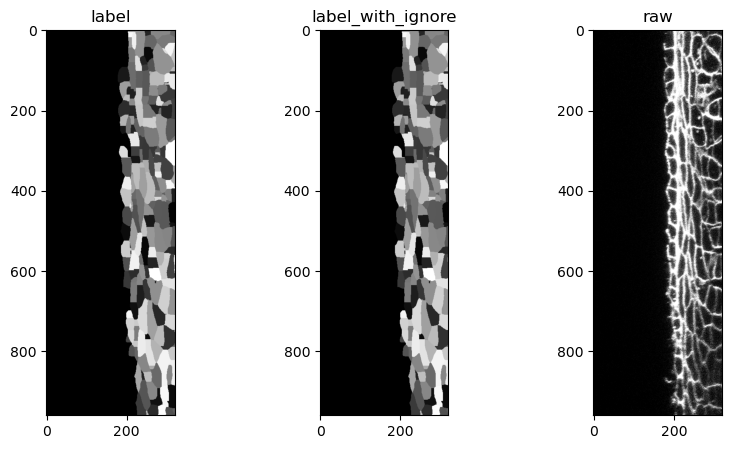

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
for idx, key in enumerate(wolny_data.keys()):
    ax[idx].imshow(wolny_data.get(key)[:, :, 500].T, cmap='gray')
    ax[idx].set_title(key)
    
plt.show()

## H5 file confirmation


In [ ]:
test_file = h5py.File("/Users/benparker/Desktop/cnl/subjects/107422_PFC_LPC_PMC.h5", 'r')

test_file.keys()

<KeysViewHDF5 ['label', 'raw']>

In [ ]:
test_file['label'].shape

(102, 256, 256, 256)

In [ ]:
test_file['raw'].shape

(1, 256, 256, 256)

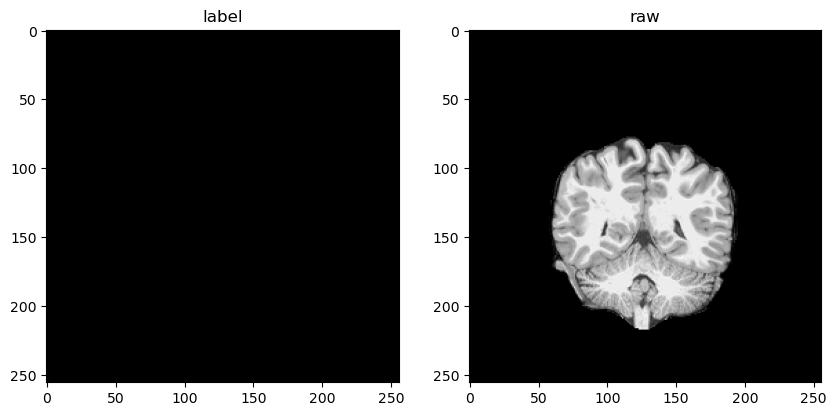

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for idx, key in enumerate(test_file.keys()):
    ax[idx].imshow(test_file.get(key)[0, :, :, 100].T, cmap='gray')
    ax[idx].set_title(key)
    

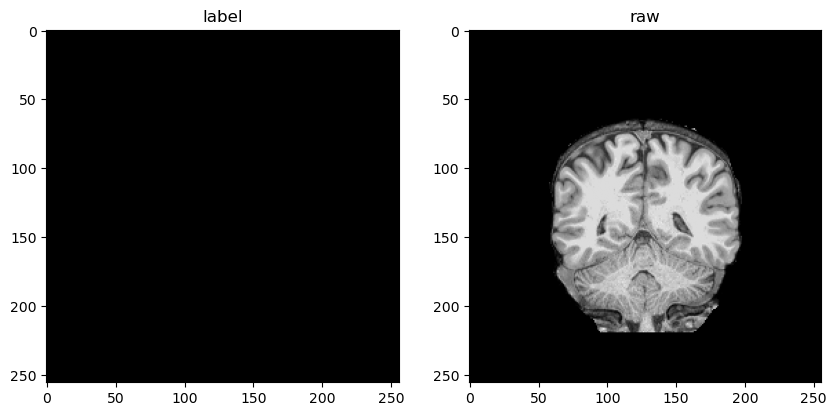

In [ ]:
test_file = h5py.File("/Users/benparker/Desktop/cnl/subjects/h5/100206_PFC_LPC_PMC.h5", 'r')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for idx, key in enumerate(test_file.keys()):
    ax[idx].imshow(test_file.get(key)[0, :, :, 100].T, cmap='gray')
    ax[idx].set_title(key)

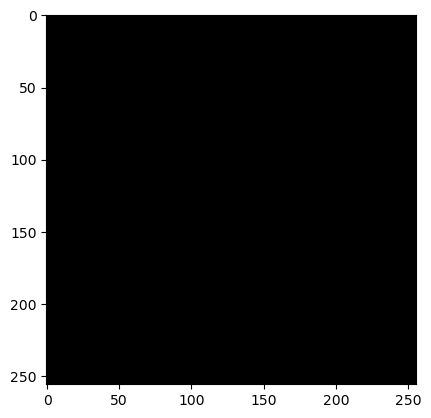

In [ ]:
plt.imshow(test_file['label'][2, :, :, 100].T, cmap='gray')

In [ ]:
np.nonzero(test_file['label'][5, :, :, :])[0][:5]

array([131, 131, 131, 131, 131])

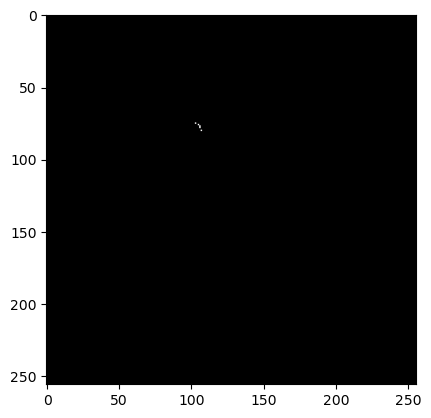

In [ ]:
plt.imshow(test_file['label'][5, 131, :, :].T, cmap='gray')

### Check labels


In [ ]:
import pandas as pd
labels = pd.read_csv('../data/all_labels_all_projects.csv')
labels.head()

,Unnamed: 0,dataset,label,count
0,0,ABIDE,lh.aparc.a2009s,125
1,1,ABIDE,Yeo_Brainmap_fsaverage_README,1
2,2,ABIDE,rh.BA4a_exvivo,125
3,3,ABIDE,lh.BA1_exvivo,125
4,4,ABIDE,lh.entorhinal_exvivo,125


In [ ]:
len(labels.label.unique())

1883

## Get sulci from label

In [ ]:

from src.freesurfer_utils import read_label
## read label


label_ind, label_RAS = read_label('../../neurocluster/weiner/HCP/projects/CNL_scalpel/HCP_YA_1200/100206/label/lh.MFSfs.label')

## read curvature

curv = nb.freesurfer.read_morph_data('../../neurocluster/weiner/HCP/subjects/100206/surf/lh.curv')


## get vertices of greater than 0 curvature


In [ ]:
label_RAS

array([[-30.802, -28.593, -34.891],
       [-33.702, -51.391, -30.272],
       [-32.403, -44.913, -32.166],
       ...,
       [-35.613, -22.481, -35.157],
       [-36.206, -22.052, -34.535],
       [-37.266, -20.435, -35.615]])

In [ ]:

sulcus_index = []
sulcus_RAS = []

for point, RAS in zip(label_ind, label_RAS):
    if curv[point] > 0:
        sulcus_index.append(point)
        sulcus_RAS.append(RAS)



In [ ]:
np.array(sulcus_index).shape[0]

217

In [ ]:
def get_sulcus(label_index: np.array, label_RAS: np.array, curv_threshold: int = 0):
    """ 
    Returns all label indices and RAS coordinates for sulcus within freesurfer label

    INPUT:
    _____
    label_index: np.array - numpy array of label indexes from src.read_label()
    label_RAS: np.array - numpy array of label RAS vertices from src.read_label()
    curv_threshold: int - value for thresholding curvature value

    OUTPUT:
    sulcus_index: np.array - numpy array of sulcus indexes from src.read_label()
    sulcus_RAS: np.array - numpy array of sulcus RAS vertices from src.read_label()

    """
        
    sulcus_index = []
    sulcus_RAS = []

    for point, RAS in zip(label_ind, label_RAS):
        if curv[point] > curv_threshold:
            sulcus_index.append(point)
            sulcus_RAS.append(RAS)
        else:
            continue
    return np.array(sulcus_index), np.array(sulcus_RAS)


def get_gyrus(label_index: np.array, label_RAS: np.array, curv_threshold: int = 0):
    """ 
    Returns all label indices and RAS coordinates for gyrus within freesurfer label

    INPUT:
    _____
    label_index: np.array - numpy array of label indexes from src.read_label()
    label_RAS: np.array - numpy array of label RAS vertices from src.read_label()
    curv_threshold: int - value for thresholding curvature value

    OUTPUT:
    gyrus_index: np.array - numpy array of gyrus indexes from src.read_label()
    gyrus_RAS: np.array - numpy array of gyrus RAS vertices from src.read_label()

    """
        
    gyrus_index = np.array([])
    gyrus_RAS = np.array([])

    for point, RAS in zip(label_ind, label_RAS):
        if curv[point] < curv_threshold:
            np.append(gyrus_index, point)
            np.append(gyrus_RAS, RAS)
        else:
            continue
    return gyrus_index, gyrus_RAS



In [ ]:
def write_label(label_indexes: np.array, label_RAS: np.array, label_name: str, hemi: str, subject_dir: str or Path, overwrite: bool = False):
    """
    Write freesurfer label file from label indexes and RAS coordinates

    INPUT:
    _____
    label_indexes: np.array - numpy array of label indexes from src.read_label()
    label_RAS: np.array - numpy array of label RAS vertices from src.read_label()
    label_name: str - name of label
    hemi: str - hemisphere of label
    subject_dir: str or Path - path to subject directory
    
    """
    
    if isinstance(subject_dir, str):
        subject_dir = Path(subject_dir)
    

    label_filename = subject_dir / 'label' / f'{hemi}.{label_name}.label'
    
    if overwrite == False:
        assert not label_filename.exists(), f"{hemi}.{label_name} already exists for subject at {subject_dir.absolute()}"

    subject_id = subject_dir.name
    label_length = label_indexes.shape[0]

    print(f'Writing label {label_filename.name} for {subject_id}')
    
    with open(label_filename.absolute(), 'w') as label_file:
        label_file.writelines(f'#!ascii label  , from subject {subject_id} vox2ras=TkReg coords=white\n')
        label_file.writelines(f'{label_length}\n')
        for i in range(label_length):
            label_line = f"{label_indexes[i]} {label_RAS[i][0]} {label_RAS[i][1]} {label_RAS[i][2]} 0.0000000000 \n"
            label_file.write(label_line)


In [ ]:
sulcus_idx, sulcus_RAS = get_sulcus(label_ind, label_RAS, curv_threshold=0)

write_label(sulcus_idx, sulcus_RAS, 'MFSfs_sulcus', 
            'lh', '/Users/benparker/Desktop/cnl/neurocluster/weiner/HCP/projects/CNL_scalpel/HCP_YA_1200/100206', True)

Writing label lh.MFSfs_sulcus.label for 100206


## Create volume from annotation

In [10]:
import src.freesurfer_utils
from pathlib import Path
import nibabel as nb
import numpy as np

subjects = src.freesurfer_utils.get_subjects_list(subjects_list='/Users/benparker/Desktop/cnl/neurocluster/weiner/HCP/subject_lists/processed_HCP_YA_1200.txt', subjects_dir = '/Users/benparker/Desktop/cnl/neurocluster/connectome-raw')

In [11]:
subjects = [Path(subject).name for subject in subjects if Path(subject).name != '926862']
subjects[:5]

['100206', '100307', '100408', '100610', '101006']

In [12]:
## Writes label files with sulcal vertices based on input labels


for hemi in ['lh', 'rh']:
    for subject in subjects:
        recon_all_dir = Path(f'/Users/benparker/Desktop/cnl/neurocluster/connectome-raw/{subject}/T1w/{subject}')
        curv_file = recon_all_dir / 'surf' / f'{hemi}.curv'
        subject_curv = nb.freesurfer.read_morph_data(curv_file.absolute())
        label_location = Path(f'{recon_all_dir}/')

        full_label_index = np.array([])
        full_label_vertices = np.empty((0, 3))
        for label in ['cortex']:
            label_filename = label_location / f'label/{hemi}.{label}.label'
            if label_filename.exists():
                continue
            else:
                print(label_filename.absolute())
                label_ind, label_RAS = src.freesurfer_utils.read_label(label_filename.absolute())
                
                full_label_index = np.concatenate((full_label_index, label_ind))
                full_label_vertices = np.vstack((full_label_vertices, label_RAS))
                sulcus_idx, sulcus_RAS = src.freesurfer_utils.get_sulcus(label_ind, label_RAS, curv = subject_curv, curv_threshold=0)
                src.freesurfer_utils.write_label(sulcus_idx, sulcus_RAS, f'cortex_sulcus',  hemi, label_location, overwrite=True)

                gyrus_idx, gyrus_RAS = src.freesurfer_utils.get_gyrus(label_ind, label_RAS, curv = subject_curv, curv_threshold=0)
                src.freesurfer_utils.write_label(gyrus_idx, gyrus_RAS, f'cortex_gyrus',  hemi, label_location, overwrite=True)
                print(f'Wrote {label}_sulcus for {subject} {hemi}')        

KeyboardInterrupt: 

In [ ]:
outdir_ctab = '/Users/benparke/Desktop/cnl/neurocluster/weiner/HCP/projects/CNL_scalpel/annot_ctab_json'
fsu.create_freesurfer_ctab('cortex_gyrus_sulcus', ['cortex_gyrus', 'cortex_sulcus'], outdir_ctab)

In [ ]:
## Creates an annotations of input labels

# label_list = ['CoS_sulcus', 'OTS_sulcus', 'MFS_sulcus', 'MFSfs_sulcus']

# for hemi in ['lh', 'rh']:
#     for subject in ['926862']:
#         subjects_dir = f'/Users/benparker/Desktop/cnl/neurocluster/connectome-raw/{subject}/T1w'
#         subject_path = f'/Users/benparker/Desktop/cnl/neurocluster/weiner/HCP/projects/CNL_scalpel/HCP_YA_1200/{subject}'
#         ctab_path = '/Users/benparker/Desktop/cnl/neurocluster/weiner/HCP/projects/CNL_scalpel/aparc_fsav_VTC.ctab'
    
#         src.freesurfer_utils.freesurfer_label2annot(subjects_dir=subjects_dir, subject_path=subject_path, label_list=label_list, hemi=hemi, ctab_path=ctab_path, annot_name='aparc_fsav_VTC')

In [ ]:
## Creates volume of input annotations

# for subject in ['926862']:
#     subjects_dir = f'/Users/benparker/Desktop/cnl/neurocluster/connectome-raw/{subject}/T1w'
#     src.freesurfer_utils.freesurfer_label2vol(subjects_dir=subjects_dir,\
#                                               subject = subject, \
#                                               hemi = 'lh',\
#                                               outfile_name = 'aparc_fsav_VTC',
#                                               annot_name = 'aparc_fsav_VTC')
    
#     src.freesurfer_utils.freesurfer_label2vol(subjects_dir=subjects_dir,\
#                                               subject = subject, \
#                                               hemi = 'rh',\
#                                               outfile_name = 'aparc_fsav_VTC',
#                                               annot_name = 'aparc_fsav_VTC')
    
    

In [ ]:
# Count and identify uncreated volumes 

count_rh = 0
unfinished_rh = []

count_lh = 0
unfinished_lh = []
for subject in subjects:
    if Path(f'/Users/benparker/Desktop/cnl/neurocluster/connectome-raw/{subject}/T1w/{subject}/mri/rh.aparc_fsav_VTC.nii.gz').exists():
        count_rh += 1
    else:
        unfinished_rh.append(subject)
    if Path(f'/Users/benparker/Desktop/cnl/neurocluster/connectome-raw/{subject}/T1w/{subject}/mri/lh.aparc_fsav_VTC.nii.gz').exists():
        count_lh += 1
    else:
        unfinished_lh.append(subject)
    

In [2]:
import numpy as np

In [6]:
## Create json for Swin-Unetr

json_nii = {"description" : "neuro-3d-ViT",
            "labels" : {
                "0" : "background",
                "1" : "CoS",
                "2" : "OTS",
                "3" : "MFS_aparc",
                "4" : "MFS_fsav"
            },
            "name" : "neuro-3d-ViT",
            "numTrain" : 880,
            "numTest" : 40,
            "reference" : "University of California, Berkeley",
            "release" : "0.1 10/3/2023",
            "tensorImageSize" : "3D",
            "test" : [],
            "training" : []
            }

fold_range = np.arange(0, 920, 40)

## Note this leaves out subject 926862 from the set, issues with annotation for that subject

for index, i in enumerate(fold_range):
    for subject in subjects[i : i + 40]:
        cluster_location_lh = f'/connectome-raw/{subject}/T1w/{subject}/mri/lh.lobesStrict_gyri_sulci.nii.gz'
        cluster_location_rh = f'/connectome-raw/{subject}/T1w/{subject}/mri/rh.lobesStrict_gyri_sulci.nii.gz'
        mount_point_json = f'/home/b-parker/Desktop/neurocluster/home'
        mount_point_local = '/Users/benparker/Desktop/cnl/neurocluster/'
        if Path(mount_point_local + cluster_location_rh).exists() and Path(mount_point_local + cluster_location_lh).exists():
            json_nii['training'].append({"fold" : index,
                                        "image" : f'/home/b-parker/Desktop/neurocluster/home/connectome-raw/{subject}/T1w/{subject}/mri/brain.mgz',
                                        "label" : [mount_point_json + cluster_location_lh, 
                                                mount_point_json + cluster_location_rh]})

In [11]:
json_nii['training'][:5]

[{'fold': 0,
  'image': '/home/b-parker/Desktop/neurocluster/home/connectome-raw/100206/T1w/100206/mri/brain.mgz',
  'label': ['/home/b-parker/Desktop/neurocluster/home/connectome-raw/100206/T1w/100206/mri/lh.lobesStrict_gyri_sulci.nii.gz',
   '/home/b-parker/Desktop/neurocluster/home/connectome-raw/100206/T1w/100206/mri/rh.lobesStrict_gyri_sulci.nii.gz']},
 {'fold': 0,
  'image': '/home/b-parker/Desktop/neurocluster/home/connectome-raw/100307/T1w/100307/mri/brain.mgz',
  'label': ['/home/b-parker/Desktop/neurocluster/home/connectome-raw/100307/T1w/100307/mri/lh.lobesStrict_gyri_sulci.nii.gz',
   '/home/b-parker/Desktop/neurocluster/home/connectome-raw/100307/T1w/100307/mri/rh.lobesStrict_gyri_sulci.nii.gz']},
 {'fold': 0,
  'image': '/home/b-parker/Desktop/neurocluster/home/connectome-raw/100408/T1w/100408/mri/brain.mgz',
  'label': ['/home/b-parker/Desktop/neurocluster/home/connectome-raw/100408/T1w/100408/mri/lh.lobesStrict_gyri_sulci.nii.gz',
   '/home/b-parker/Desktop/neurocluster

In [12]:
# Write json 
import json
json_filepath = '/Users/benparker/Desktop/cnl/neurocluster/weiner/HCP/projects/CNL_scalpel/linux_lobesStrict_gyri_sulci.json'

with open(json_filepath, 'w') as fp:
    json.dump(json_nii, fp)
    fp.close()
 

MRIS_anatomical


In [1]:
import src.freesurfer_utils as fsu
from pathlib import Path


subjects_dir = "/Users/benparker/Desktop/cnl/neurocluster/Urgency/subjects"
subjects_path_list = fsu.get_subjects_list(subjects_dir=subjects_dir, 
                                           subjects_list="/Users/benparker/Desktop/cnl/neurocluster/Urgency/subjects/pcc_sub_list.txt")

In [4]:
subjects = [Path(subject_path).name for subject_path in subjects_path_list]
pcc_labels = ['1', '2', '3', 'MCGS', 'POS', 'prcus1', 'prcus2', 'prcus3', 'prculs', 'sbps', 'sps', 'w', 'x', 'y']


df = fsu.subject_label_stats2DataFrame(subjects_dir, subjects, pcc_labels, 'both', data_dir_from_subject_fs_dir = 'label/label_stats', must_exist=False)

   sub hemi label  num_vertices  surface_area_mm^2  gray_matter_volume_mm^3  \
0  103   lh     2         224.0              165.0                    464.0   

   avg_cortical_thickness  avg_cortical_thickness_std  \
0                   2.972                       0.451   

   rectified_mean_curvature  rectified_gaussian_curvature  folding_index  \
0                     0.116                         0.022            1.0   

   intrinsic_curvature  
0                  0.2  
   sub hemi label  num_vertices  surface_area_mm^2  gray_matter_volume_mm^3  \
0  103   lh     3         104.0               85.0                    301.0   

   avg_cortical_thickness  avg_cortical_thickness_std  \
0                   3.432                       0.371   

   rectified_mean_curvature  rectified_gaussian_curvature  folding_index  \
0                     0.153                         0.039            1.0   

   intrinsic_curvature  
0                  0.1  
   sub hemi label  num_vertices  surface_area_